In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import logging

import scipy.stats
import numpy as np

In [2]:
from batchglm.api.models.nb_glm import Simulator
import diffxpy.api as de

In [3]:
logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("batchglm").setLevel(logging.INFO)
logging.getLogger("diffxpy").setLevel(logging.INFO)

# Generate some data:

In [4]:
sim = Simulator(num_observations=2000, num_features=100)
sim.generate_sample_description(num_batches=0, num_conditions=2)
# sample parameters from positive truncated N(1, 0.1)
mu=1; phi=0.1
sim.generate_params(rand_fn_loc=lambda size: mu + scipy.stats.truncnorm.rvs(-mu / phi, np.infty, scale=phi, size=size))
sim.generate_data()

X = sim.X # count data
sample_description = sim.sample_description

The sample description should be a pandas DataFrame with `num_observations` rows.
Each column should represent a property of the dataset.

The module `batchglm.api.data` contains some helper functions which can be useful to create this sample description:

- `sample_description_from_anndata()`
- `sample_description_from_xarray()`

In [5]:
sample_description.iloc[:10,:]

,condition
observations,
0,0
1,1
2,0
3,1
4,0
5,1
6,0
7,1
8,0


# Run differential expression test

The wald test checks if a certain coefficient introduces a significant difference in the expression of a gene.

It needs a statistical formula `formula` which describes the setup of the model and the factor of the formula `factor_loc_totest` which should be tested.

Usually, this factor divides the samples into two groups, e.g. `condition 0` and `condition 1`.
In this case, diffxpy will automatically choose the coefficient to test.
If there are more than two groups specified by the factor, the coefficient which should be tested has to be set manually by specifying `coef_totest`. This coefficient should refer to one of the groups specified by `factor_loc_totest`, e.g. `condition 1`.


In [6]:
test = de.test.wald(
    data=X,
    formula="~ 1 + condition",
    factor_loc_totest="condition",
    sample_description=sample_description,
    training_strategy="QUICK",
    dtype="float64"
)

INFO:diffxpy.testing.base:Fitting model...


/Users/david.fischer/miniconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/Users/david.fischer/miniconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/Users/david.fischer/miniconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/Users/david.fischer/miniconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


# Obtain the results

The p-/q-values can be obtained by calling test.pval / test.qval:

In [7]:
test.pval[:10]

array([2.79299126e-01, 6.51163161e-01, 3.28626015e-14, 5.59529531e-04,
       1.00138131e-08, 2.94738522e-01, 1.12216855e-01, 0.00000000e+00,
       1.77635684e-15, 6.37424916e-04])

In [8]:
test.qval[:10]

array([3.21033478e-01, 6.85920643e-01, 1.82570008e-13, 9.17261526e-04,
       3.23026229e-08, 3.34930139e-01, 1.40271069e-01, 0.00000000e+00,
       1.26882631e-14, 1.02810470e-03])

test.summary() returns a pandas DataFrame with a quick overview of the test results:

In [9]:
test.summary().iloc[:10,:]

,gene,pval,qval,log2fc,mean,grad,coef_mle,coef_sd,ll
0,0,2.792991e-01,3.210335e-01,-0.016729,7927.2680,0.242761,-0.016729,0.015463,-18587.560455
1,1,6.511632e-01,6.859206e-01,0.008385,1009.6470,0.119787,0.008385,0.018545,-14782.200455
2,2,3.286260e-14,1.825700e-13,-0.127129,8168.8705,0.041874,-0.127129,0.016758,-18776.093203
3,3,5.595295e-04,9.172615e-04,-0.064079,9364.0610,0.099905,-0.064079,0.018571,-19213.137339
4,4,1.001381e-08,3.230262e-08,0.105365,4308.7030,0.134710,0.105365,0.018387,-17677.018330
5,5,2.947385e-01,3.349301e-01,0.028158,6282.3170,0.173685,0.028158,0.026874,-18995.771872
6,6,1.122169e-01,1.402711e-01,-0.022300,1149.7555,0.419735,-0.022300,0.014040,-14543.452087
7,7,0.000000e+00,0.000000e+00,0.173886,9321.5925,0.027267,0.173886,0.018853,-19253.362136
8,8,1.776357e-15,1.268826e-14,0.223681,8466.4035,0.088808,0.223681,0.028123,-19670.964029
9,9,6.374249e-04,1.028105e-03,-0.068308,7949.8100,0.197563,-0.068308,0.020001,-19048.442094


- `gene`: gene name / identifier
- `pval`: p-value of the gene
- `qval`: multiple testing - corrected p-value of the gene
- `log2fc`: log_2 fold change between `no coefficient` and `coefficient`
- `grad`: the gradient of the gene's log-likelihood
- `coef_mle` the maximum-likelihood estimate of the coefficient in liker-space
- `coef_sd` the standard deviation of the coefficient in liker-space
- `ll`: the log-likelihood of the estimation

`test.plot_volcano()` creates a volcano plot of p-values vs. fold-change:

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c367b1240>)

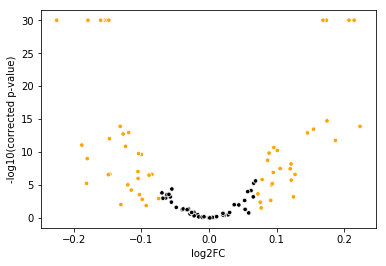

In [21]:
test.plot_volcano(corrected_pval=True, min_fc=1.05, alpha=0.05, size=20)

`plot_vs_ttest()` shows the correlation between t-test p-values and the wald test p-values

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c35952438>)

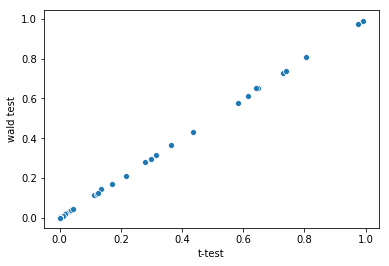

In [11]:
test.plot_vs_ttest()

`test.plot_diagnostics()` is a shortcut to directly show all diagnostics plots.

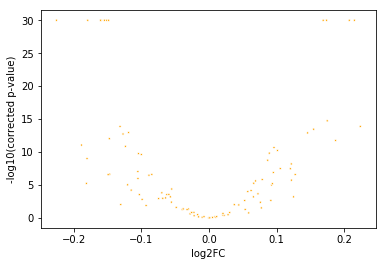

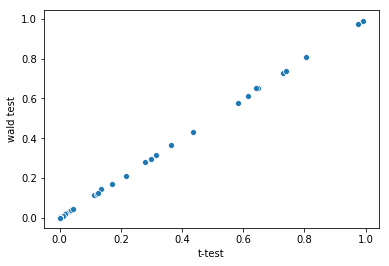

In [12]:
test.plot_diagnostics()